In [1]:
import torch
import os
import ray
import re
import pickle
import csv
import numpy as np
import json
import modin.pandas as pd
from datetime import datetime, timezone, timedelta
from numba import cuda
from tqdm import tqdm
from cuml import HDBSCAN
from cuml import UMAP
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

In [2]:
ray.init(include_dashboard=False)

2024-03-26 18:32:21,517	WARNING utils.py:575 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2024-03-26 18:32:21,518	WARNING utils.py:587 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 30.71999 to 30.
2024-03-26 18:32:21,613	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.9.0


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 90)

In [4]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

with open("datasets/german_stopwords_simple.txt", encoding="utf-8") as f:
     stopw_cleaner = [line.lower().rstrip('\n') for line in f]

def clean_text_3(words, stopwords=stopw_cleaner):
    non_words = ["gt", "ml", "mg", ":)", ":("]
    remove_words = non_words
    re_wspace = re.compile(r"\s+", re.IGNORECASE)
    re_ascii = re.compile(r"[^A-Za-zÀ-ž,?!.:() ]", re.IGNORECASE)
    re_ascii_2 = re.compile(r"[^A-Za-zÀ-ž,?!.: ]", re.IGNORECASE)
    re_singlechar = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    re_endtags = re.compile(r"[#]\w+\b(?!\W*\s\w)", re.IGNORECASE)
    re_multipunct = re.compile(r"(?<=[^!?.:,>$%&-][!?.:,>$%&-])[!?.:,>$%& -]+(?<! )", re.IGNORECASE)
    no_numeric_hashtag = re.sub("#[0-9]+","", words)
    no_endtags = re.sub(re_endtags, "", no_numeric_hashtag)
    no_url = re.sub(r"http\S+", "", no_endtags)
    no_mention = re.sub("@[A-Za-z0-9_.\-]+","", no_url)
    words = re.sub(r'(RT)+',"", no_mention)
    words = re.sub(r'^(TUSERUSER)+',"", words)
    words = re.sub(r'^(RT TUSERUSER)+',"", words)
    words = re.sub(r'^(Re)+',"", words)
    words = re.sub(re_ascii, " ", words)
    words = re.sub(re_multipunct, " ", words)
    tokenized = tweet_tokenizer.tokenize(words)
    words = ' '.join([word for word in tokenized if word.lower() not in remove_words])
    words = re.sub(re_ascii_2, " ", words)
    words = re.sub(re_singlechar, " ", words)
    words = re.sub(re_wspace, " ", words)
    words = re.sub(r'\s([,?!.:](?:\s|$))', r'\1', words)
    words = re.sub(r"(?<!\S)\S(?!\S).?", "", words)
    words = words.strip()
    words = words.lstrip(punctuation)
    words = words.rstrip("#%&()*+,-/:;<=>@[\]^_`{|}~")
    words = words.strip() 
    return words

In [5]:
vegan_slim_food_only = pd.read_csv("datasets/veg_lm_colab_new.csv")
vegan_slim_food_only =  vegan_slim_food_only.sort_values(by='date').reset_index(drop=True)
date_mask_2 = vegan_slim_food_only['date'] < '2022-09-01'
vegan_slim_food_only = vegan_slim_food_only.loc[date_mask_2]
display(vegan_slim_food_only.head())
vegan_slim_food_only.info()

,date,tweet
0,2011-06-01,@UxCampEurope Wird es eventuell auch vegetarisches/veganes Essen geben?
1,2011-06-01,"also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au..."
2,2011-06-01,"hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein ""Spontan-B..."
3,2011-06-01,#Grillen und Fleisch - ein Muss? Schließlich gibt es sehr leckere #vegetarische #Grill...
4,2011-06-01,#Fleisch #Vegetarier Schock-Bilder lösen Exportstopp für Rinder aus http://goo.gl/1sznx


<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 501677 entries, 0 to 501676
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  ---------------  ----- 
 0   date    501677 non-null  object
 1   tweet   501677 non-null  object
dtypes: object(2)
memory usage: 11.5 MB


In [6]:
mask_len = vegan_slim_food_only['tweet'].str.len() > 20
vegan_slim_food_only = vegan_slim_food_only.loc[mask_len]
vegan_slim_food_only = vegan_slim_food_only.drop_duplicates(subset='tweet').replace(r'^\s*$', np.nan, regex=True).dropna().reset_index(drop=True)
display(vegan_slim_food_only.head())
vegan_slim_food_only.info()

,date,tweet
0,2011-06-01,@UxCampEurope Wird es eventuell auch vegetarisches/veganes Essen geben?
1,2011-06-01,"also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au..."
2,2011-06-01,"hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein ""Spontan-B..."
3,2011-06-01,#Grillen und Fleisch - ein Muss? Schließlich gibt es sehr leckere #vegetarische #Grill...
4,2011-06-01,#Fleisch #Vegetarier Schock-Bilder lösen Exportstopp für Rinder aus http://goo.gl/1sznx


<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 501550 entries, 0 to 501549
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  ---------------  ----- 
 0   date    501550 non-null  object
 1   tweet   501550 non-null  object
dtypes: object(2)
memory usage: 7.7 MB


In [7]:
timestamps_no_preprocessing = vegan_slim_food_only["date"].tolist()

In [8]:
docs_untouched = vegan_slim_food_only["tweet"].tolist()

In [9]:
%%time

vegan_slim_food_only['clean_tweet'] = vegan_slim_food_only['tweet'].apply(lambda x: clean_text_3(x))
vegan_slim_food_only = vegan_slim_food_only.drop_duplicates(subset="clean_tweet").replace(r'^\s*$', np.nan, regex=True).dropna().reset_index(drop=True)
display(vegan_slim_food_only.head())
display(vegan_slim_food_only.info())

,date,tweet,clean_tweet
0,2011-06-01,@UxCampEurope Wird es eventuell auch vegetarisches/veganes Essen geben?,Wird es eventuell auch vegetarisches veganes Essen geben?
1,2011-06-01,"also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au...","also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au..."
2,2011-06-01,"hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein ""Spontan-B...",hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein Spontan Bu...
3,2011-06-01,#Grillen und Fleisch - ein Muss? Schließlich gibt es sehr leckere #vegetarische #Grill...,Grillen und Fleisch ein Muss? Schließlich gibt es sehr leckere Alternativen
4,2011-06-01,#Fleisch #Vegetarier Schock-Bilder lösen Exportstopp für Rinder aus http://goo.gl/1sznx,Vegetarier Schock Bilder lösen Exportstopp für Rinder aus


<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 442141 entries, 0 to 442140
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  -----------  ---------------  ----- 
 0   date         442141 non-null  object
 1   tweet        442141 non-null  object
 2   clean_tweet  442141 non-null  object
dtypes: object(3)
memory usage: 10.1 MB


None

CPU times: user 1.01 s, sys: 222 ms, total: 1.23 s
Wall time: 6.34 s


In [10]:
display(vegan_slim_food_only.head(15))

,date,tweet,clean_tweet
0,2011-06-01,@UxCampEurope Wird es eventuell auch vegetarisches/veganes Essen geben?,Wird es eventuell auch vegetarisches veganes Essen geben?
1,2011-06-01,"also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au...","also dieser veganer disqualifiziert sich grad selber, weil er die diskussion wieder au..."
2,2011-06-01,"hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein ""Spontan-B...",hat gerade riesen Lust auf einen fetttriefenden Hamburger! Zu dumm das mein Spontan Bu...
3,2011-06-01,#Grillen und Fleisch - ein Muss? Schließlich gibt es sehr leckere #vegetarische #Grill...,Grillen und Fleisch ein Muss? Schließlich gibt es sehr leckere Alternativen
4,2011-06-01,#Fleisch #Vegetarier Schock-Bilder lösen Exportstopp für Rinder aus http://goo.gl/1sznx,Vegetarier Schock Bilder lösen Exportstopp für Rinder aus
5,2011-06-01,#lebensmittel #3: 400 mg Grüner Tee Extrakt 90 vegetarische Kapseln: 400 mg Grüner Tee...,lebensmittel: Grüner Tee Extrakt vegetarische Kapseln: Grüner Tee Extrakt vegetarische.
6,2011-06-01,RT @ItsDefne: WTF so ein Lehrer ist Veganer und will nur veganes Essen auf dem Schulfe...,WTF so ein Lehrer ist Veganer und will nur veganes Essen auf dem Schulfest verkaufen u...
7,2011-06-01,veganer essen meinem essen das essen weg! ;-) warum müssen die immer versuchen zu miss...,veganer essen meinem essen das essen weg! warum müssen die immer versuchen zu missioni...
8,2011-06-01,#2: Dead Sea Premier Aromatische Körper Butter - pflanzlich - 175 ml: Dead Sea Premier...,Dead Sea Premier Aromatische Körper Butter pflanzlich: Dead Sea Premier Aromatische Kö...
9,2011-06-01,Vegetarische Ernährung News | Mark Zuckerberg braucht kein Fleisch - paradisi.de http...,Vegetarische Ernährung News Mark Zuckerberg braucht kein Fleisch paradisi.de


In [11]:
docs =  vegan_slim_food_only["clean_tweet"].tolist()
timestamps = vegan_slim_food_only["date"].tolist()

In [12]:
from sentence_transformers import SentenceTransformer

In [13]:
display(torch.cuda.is_available())
display(torch.cuda.device_count())
display(torch.cuda.current_device())
cuda_device = torch.cuda.current_device()

True

1

0

In [14]:
sentence_model = SentenceTransformer("sentence_models/pretrained/dell_research_harvard_lt_wikidata_comp_de_2nd_update", device=cuda_device)

In [15]:
# Loading preparated embeddings for preprocessed documents, performed on an nvidia L40 GPU
with open("tweets_timestamps/docs_new_preprocessing_v6.pkl", "rb") as f:
    docs = pickle.load(f)

with open("tweets_timestamps/timestamps_new_preprocessing_v6.pkl", "rb") as f:
    timestamps = pickle.load(f)

with open("embeddings/embeddings_dell_research_harvard_lt_wikidata_comp_de_2nd_update_new_preprocessing_l40_v6.pkl", "rb") as f:
    embeddings = pickle.load(f)

In [16]:
system_prompt = """
<s>[INST] <<SYS>>
Du bist ein hilfreicher, respektvoller und ehrlicher Assistent. Du sprichst ausschließlich deutsch. Verwende keine Emojis oder Emoticons in deinen Antworten.
<</SYS>>
"""

example_prompt = """
Ich habe ein Thema, das die folgenden Dokumente enthält:
- Die traditionelle Ernährung in den meisten Kulturen basierte in erster Linie auf pflanzlichen Lebensmitteln mit ein wenig Fleisch als Zugabe.
- Fleisch, insbesondere Rindfleisch, ist das emissionsstärkste Lebensmittel.
- Wer Fleisch isst, ist kein schlechter Mensch, wer kein Fleisch isst, ist kein guter Mensch.

Das Thema wird durch die folgenden Schlüsselwörter beschrieben: 'Fleisch, Rindfleisch, essen, essen, Emissionen, Steak, Lebensmittel, Gesundheit, verarbeitet, Huhn'.

Erstelle auf der Grundlage der obigen Informationen zum Thema eine kurze, aussagekräftige Überschrift. Gib nur die Überschrift aus, sonst nichts weiter.
[/INST] Umweltauswirkungen des Fleischkonsums</s><s>
"""

main_prompt = """
[INST]
Ich habe ein Thema, das die folgenden Dokumente enthält:
[DOCUMENTS]

Das Thema wird durch die folgenden Schlüsselwörter beschrieben: '[KEYWORDS]'.

Erstelle auf der Grundlage der obigen Informationen zum Thema eine kurze, aussagekräftige Überschrift. Gib nur die Überschrift aus, sonst nichts weiter.
[/INST]
"""

prompt = system_prompt + example_prompt + main_prompt
print(prompt)


<s>[INST] <<SYS>>
Du bist ein hilfreicher, respektvoller und ehrlicher Assistent. Du sprichst ausschließlich deutsch. Verwende keine Emojis oder Emoticons in deinen Antworten.
<</SYS>>

Ich habe ein Thema, das die folgenden Dokumente enthält:
- Die traditionelle Ernährung in den meisten Kulturen basierte in erster Linie auf pflanzlichen Lebensmitteln mit ein wenig Fleisch als Zugabe.
- Fleisch, insbesondere Rindfleisch, ist das emissionsstärkste Lebensmittel.
- Wer Fleisch isst, ist kein schlechter Mensch, wer kein Fleisch isst, ist kein guter Mensch.

Das Thema wird durch die folgenden Schlüsselwörter beschrieben: 'Fleisch, Rindfleisch, essen, essen, Emissionen, Steak, Lebensmittel, Gesundheit, verarbeitet, Huhn'.

Erstelle auf der Grundlage der obigen Informationen zum Thema eine kurze, aussagekräftige Überschrift. Gib nur die Überschrift aus, sonst nichts weiter.
[/INST] Umweltauswirkungen des Fleischkonsums</s><s>

[INST]
Ich habe ein Thema, das die folgenden Dokumente enthält:
[D

In [17]:
from bertopic.representation import LlamaCPP
from llama_cpp import Llama

llm = Llama(model_path="gguf_models/Llama-2-13b-chat-german-GGUF.q5_K_M.bin", verbose=False, n_ctx=4096, n_gpu_layers=-1, n_threads=30, offload_kqv=True, n_batch=512)

llama_cpp = LlamaCPP(llm, nr_docs=15, prompt=prompt, pipeline_kwargs = {'repeat_penalty': 1.1, 'max_tokens': 150, 'temperature': 0.1})

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4090, compute capability 8.9, VMM: yes
llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from gguf_models/Llama-2-13b-chat-german-GGUF.q5_K_M.bin (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forwa

In [18]:
# Defining timezone offset

timezone_offset = +2.0
tzinfo = timezone(timedelta(hours=timezone_offset))

In [19]:
with open("datasets/stop_words_german.txt", encoding="utf-8") as f:
     stopw_ger = [line.lower().rstrip('\n') for line in f]

In [20]:
umap_model = UMAP(
    n_neighbors=20, 
    n_components=5, 
    metric='cosine', 
    min_dist=0.0,
    random_state=42,
    init="random",
    verbose=True
)

hdb_min_cluster_size = 62

hdbscan_model = HDBSCAN(
    min_cluster_size=hdb_min_cluster_size, 
    # min_samples=40,
    min_samples=hdb_min_cluster_size,
    # cluster_selection_epsilon=0.0,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=False,
    verbose=True
)


ctfidf_model = ClassTfidfTransformer(bm25_weighting=False, reduce_frequent_words=True)

vectorizer_model = CountVectorizer(
    # tokenizer=nltk_tweettokenizer,
    # min_df=0.1,
    # vocabulary=vocab,
    lowercase = False,
    stop_words=stopw_ger,
    max_df=0.8,
    ngram_range=(1, 2)
)

In [21]:
representation_model = [llama_cpp]

In [22]:
%%time

bto_germansemantic = BERTopic(
    vectorizer_model=vectorizer_model, 
    embedding_model=sentence_model, 
    ctfidf_model=ctfidf_model, 
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    # n_gram_range=(1, 2), 
    min_topic_size=hdb_min_cluster_size, 
    # nr_topics="auto", 
    nr_topics=41, 
    calculate_probabilities=False, 
    verbose=True, 
    top_n_words=15
)

params_dict_0 = bto_germansemantic.get_params(deep=True)

c_vec_stopwords = params_dict_0['vectorizer_model__stop_words']
if params_dict_0['vectorizer_model__stop_words'] is not None:
    c_vec_stopwords = len(params_dict_0['vectorizer_model__stop_words'])

print(f"Parameters used in last run, {datetime.now(tzinfo).strftime('%H:%M:%S %d.%m.%Y')}\n")
print("UMAP:")
print(f"\tn_neighbors = {params_dict_0['umap_model__n_neighbors']}")
print(f"\tn_components = {params_dict_0['umap_model__n_components']}")
print(f"\tmin_dist = {params_dict_0['umap_model__min_dist']}")
print(f"\tmetric = {params_dict_0['umap_model__metric']}\n")
print("HDBSCAN:")
print(f"\tmetric = {params_dict_0['hdbscan_model__metric']}")
print(f"\tmin_cluster_size = {params_dict_0['hdbscan_model__min_cluster_size']}")
print(f"\tmin_samples = {params_dict_0['hdbscan_model__min_samples']}")
print(f"\tcluster_selection_epsilon = {params_dict_0['hdbscan_model__cluster_selection_epsilon']}")
print(f"\tprediction_data = {params_dict_0['hdbscan_model__prediction_data']}")
print(f"\tconnectivity = {params_dict_0['hdbscan_model__connectivity']}\n")
print("Vectorizer:")
print(f"\tlowercase = {params_dict_0['vectorizer_model__lowercase']}")
print(f"\tmax_df = {params_dict_0['vectorizer_model__max_df']}")
print(f"\tngram_range = {params_dict_0['vectorizer_model__ngram_range']}")
print(f"\tstop_words = {c_vec_stopwords}")
print(f"\ttokenizer = {params_dict_0['vectorizer_model__tokenizer']}")
print(f"\tstrip_accents = {params_dict_0['vectorizer_model__strip_accents']}\n")
print("c-TF-IDF:")
print(f"\tbm25_weighting = {params_dict_0['ctfidf_model__bm25_weighting']}")
print(f"\treduce_frequent_words= {params_dict_0['ctfidf_model__reduce_frequent_words']}\n")
print("Representation Model:")
for i in range(len(params_dict_0['representation_model'])):
    print(f"\t{type(params_dict_0['representation_model'][i]).__name__}:")
    for k, v in vars(params_dict_0['representation_model'][i]).items():
        print(f"\t\t{k} = {v}")
print("\nTopic Model:")
print(f"\tembedding_model = {type(params_dict_0['embedding_model'][0]).__name__}, {type(params_dict_0['embedding_model'][0].__dict__['_modules']['auto_model']).__name__}")
print(f"\tmin_topic_size = {params_dict_0['min_topic_size']}")
print(f"\tnr_topics = {params_dict_0['nr_topics']}")
print(f"\tlow_memory = {params_dict_0['low_memory']}")
print(f"\tn_gram_range = {params_dict_0['n_gram_range']}")
print(f"\ttop_n_words = {params_dict_0['top_n_words']}\n")

topics, probs = bto_germansemantic.fit_transform(
    docs, 
    embeddings
)

2024-03-26 18:32:58,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Parameters used in last run, 19:32:58 26.03.2024

UMAP:
	n_neighbors = 20
	n_components = 5
	min_dist = 0.0
	metric = cosine

HDBSCAN:
	metric = euclidean
	min_cluster_size = 62
	min_samples = 62
	cluster_selection_epsilon = 0.0
	prediction_data = False
	connectivity = knn

Vectorizer:
	lowercase = False
	max_df = 0.8
	ngram_range = (1, 2)
	stop_words = 604
	tokenizer = None
	strip_accents = None

c-TF-IDF:
	bm25_weighting = False
	reduce_frequent_words= True

Representation Model:
	LlamaCPP:
		model = <llama_cpp.llama.Llama object at 0x7fc0de870e20>
		prompt = 
<s>[INST] <<SYS>>
Du bist ein hilfreicher, respektvoller und ehrlicher Assistent. Du sprichst ausschließlich deutsch. Verwende keine Emojis oder Emoticons in deinen Antworten.
<</SYS>>

Ich habe ein Thema, das die folgenden Dokumente enthält:
- Die traditionelle Ernährung in den meisten Kulturen basierte in erster Linie auf pflanzlichen Lebensmitteln mit ein wenig Fleisch als Zugabe.
- Fleisch, insbesondere Rindfleisch, ist das

2024-03-26 18:33:33,453 - BERTopic - Dimensionality - Completed ✓
2024-03-26 18:33:33,457 - BERTopic - Cluster - Start clustering the reduced embeddings


[D] [18:33:33.399851] /__w/cuml/cuml/cpp/src/umap/runner.cuh:382 Smoothing KNN distances
[D] [18:33:33.403327] /__w/cuml/cuml/cpp/src/umap/runner.cuh:414 Executing fuzzy simplicial set
[D] [18:33:33.408780] /__w/cuml/cuml/cpp/src/umap/runner.cuh:443 Performing L1 normalization
[D] [18:33:33.410948] /__w/cuml/cuml/cpp/src/umap/runner.cuh:479 n_epochs=30
[D] [18:33:33.414209] /__w/cuml/cuml/cpp/src/umap/runner.cuh:502 Computing # of epochs for training each sample
[D] [18:33:33.414473] /__w/cuml/cuml/cpp/src/umap/runner.cuh:509 Performing optimization


2024-03-26 18:33:50,371 - BERTopic - Cluster - Completed ✓
2024-03-26 18:33:50,372 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 162/162 [01:52<00:00,  1.45it/s]
2024-03-26 18:36:15,862 - BERTopic - Representation - Completed ✓
2024-03-26 18:36:15,896 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
2024-03-26 18:37:17,085 - BERTopic - Topic reduction - Reduced number of topics from 162 to 41


CPU times: user 3min 59s, sys: 20.7 s, total: 4min 20s
Wall time: 4min 19s


In [23]:
bto_germansemantic.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,342401,-1_Vegane Ernährung: Vor- und Nachteile\n\n\n ___,"[Vegane Ernährung: Vor- und Nachteile\n\n\n , , , , , , , , , ]",[Man muss ja nicht jeden Tag Fleisch essen. Das ist glaube ich ein Großer Fehler der L...
1,0,40416,0_Vegane Fleischersatzprodukte: Eine neue Generation von Geschmack und Umweltfreundlic...,[Vegane Fleischersatzprodukte: Eine neue Generation von Geschmack und Umweltfreundlich...,[Salonfähig: Unsere Auswah heute vegan Karotten Kokos Suppe vegan Tortellini Salat veg...
2,1,30980,1_Vegane Ernährung: Vorteile für Menschen und Tiere ___,"[Vegane Ernährung: Vorteile für Menschen und Tiere , , , , , , , , , ]","[Verzicht auf tierische Produkte: Wie gesund ist vegane Ernährung?, Fleischkonsum ist ..."
3,2,16324,"2_Vegane Milch und Käse: Ein ethischer Ausweg für Tiere, Menschen und die Umwelt ___","[Vegane Milch und Käse: Ein ethischer Ausweg für Tiere, Menschen und die Umwelt , , , ...","[Eine Frage die es so früher nicht gab: Was trinkst du für Milch? Cashew Milch, Reis M..."
4,3,1264,3_Vegane Ernährung: Wie man Proteine und Calcium ohne tierische Produkte aufnimmt ___,"[Vegane Ernährung: Wie man Proteine und Calcium ohne tierische Produkte aufnimmt , , ,...","[Lebensmittel, die Kalzium enthalten, sind bestimmte Hülsenfrüchte, bestimmte grüne Bl..."
5,4,1063,4_Veganes Essen: Ein kontroverses Thema ___,"[Veganes Essen: Ein kontroverses Thema , , , , , , , , , ]","[Man hat festgestellt, das Veganer kaum Corona bekommen. Der Verzicht auf Fleisch hilf..."
6,5,909,5_Vegane Lebensmittel: Beyond Meat und Co. erobern den Markt ___,"[Vegane Lebensmittel: Beyond Meat und Co. erobern den Markt , , , , , , , , , ]","[NEU lebensmittel Sampling im er Team diese Woche MI, DO, FR, SA Verteile kostenlose P..."
7,6,868,6_Vegetarisches Cordon Bleu: Eine französische Leidenschaft ___,"[Vegetarisches Cordon Bleu: Eine französische Leidenschaft , , , , , , , , , ]","[Und für morgen dann das vegetarische Cordon Bleu., Habe jetzt vegetarisches Cordon Bl..."
8,7,779,7_Soja für Tierfutter: Der Regenwald brennt für Rindfleisch ___,"[Soja für Tierfutter: Der Regenwald brennt für Rindfleisch , , , , , , , , , ]","[Das mit den Avocados ist Wasserverschwendung, das stimmt. Aber man isst als Veganer a..."
9,8,745,8_Veganer und Pilze: Ein ethischer Konflikt ___,"[Veganer und Pilze: Ein ethischer Konflikt , , , , , , , , , ]","[Liebe Veganer, bitte hört auf Pilze zu essen! Da wohnen Schlümpfe drin., Liebe Vegane..."


In [24]:
import datamapplot

In [25]:
reduced_embeddings = UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine', random_state=42, init="random", verbose=True).fit_transform(embeddings)

[D] [18:37:49.714932] /__w/cuml/cuml/cpp/src/umap/runner.cuh:108 n_neighbors=20
[D] [18:37:49.716810] /__w/cuml/cuml/cpp/src/umap/runner.cuh:130 Calling knn graph run
[D] [18:38:02.083562] /__w/cuml/cuml/cpp/src/umap/runner.cuh:136 Done. Calling fuzzy simplicial set
[D] [18:38:02.089835] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:317 Smooth kNN Distances
[D] [18:38:02.089942] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:319 sigmas = [ 0.10503, 0.131062, 0.0656648, 0.0836465, 0.163644, 0.316543, 0.0632045, 0.0107452, 0.133756, 0.138902, 0.10778, 0.107426, 0.00691491, 0.171838, 0.0933895, 0.0550342, 0.192851, 0.122528, 0.0752727, 0.140727, 0.041388, 0.100632, 0.152178, 0.0402781, 0.241453 ]

[D] [18:38:02.089968] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:321 rhos = [ 2.38419e-07, 4.76837e-07, 5.96046e-08, 6.55651e-07, 5.96046e-07, 4.17233e-07, 1.19209e-07, 0.130579, 2.98023e-07, 2.38419e-07, 4.17233e-07, 5.96046e-08, 0.179306, 2.38419e-07, 2.38419e-07, 1.7

In [26]:
llm_labels = [re.sub(r'[^A-Za-zÀ-ž,?!.:]', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in bto_germansemantic.get_topics(full=True)["Main"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+bto_germansemantic._outliers] if topic != -1 else "Unlabelled" for topic in topics]

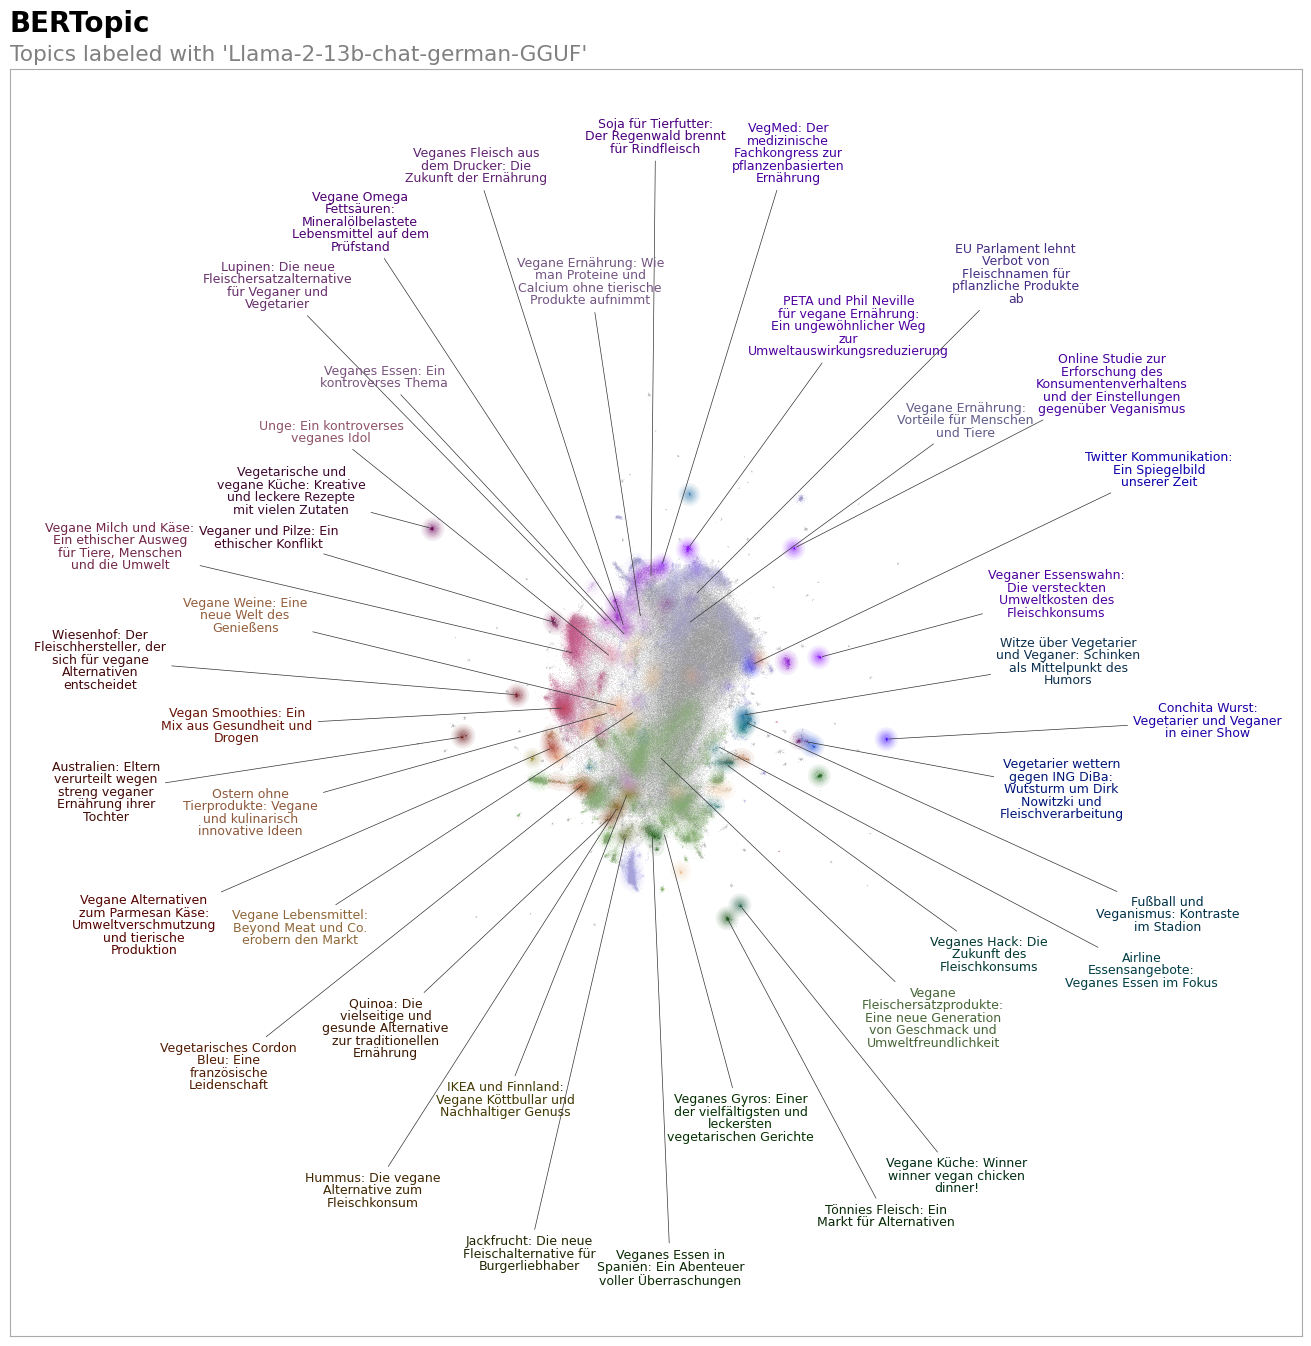

In [27]:
fig, ax = datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=9,
    title="BERTopic",
    sub_title="Topics labeled with 'Llama-2-13b-chat-german-GGUF'",
    label_wrap_width=22,
    label_margin_factor=2.1,
    use_medoids=True,
    figsize=(13, 13)
)